# Asynchronous Processing

While many parallel applications can be described as maps, some can be more complex.
In this section we look at the asynchronous `concurrent.futures` interface,
which provides a simple API for ad-hoc parallelism.
This is useful for when your computations don't fit a regular pattern.

## Executor.submit

The `submit` method starts a computation in a separate thread or process and immediately gives us a `Future` object that refers to the result.  At first, the future is pending.  Once the function completes the future is finished. 

We collect the result of the task with the `.result()` method,
which does not return until the results are available.

In [ ]:
%%time
from time import sleep

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

slowadd(1,1)

CPU times: user 3.16 ms, sys: 1.34 ms, total: 4.5 ms
Wall time: 1 s


2

In [ ]:
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(1) as e:
    future = e.submit(slowadd, 1, 2)
    print(future.result())


3


## Submit many tasks, receive many futures

Because submit returns immediately we can submit many tasks all at once and they will execute in parallel.

In [ ]:
%%time
results = [slowadd(i, i, delay=1) for i in range(8)]
print(results)

[0, 2, 4, 6, 8, 10, 12, 14]
CPU times: user 1.66 ms, sys: 2.47 ms, total: 4.14 ms
Wall time: 8.01 s


In [ ]:
%%time
e = ThreadPoolExecutor()
futures = [e.submit(slowadd, i, i, delay=1) for i in range(8)]
results = [f.result() for f in futures]
print(results)

[0, 2, 4, 6, 8, 10, 12, 14]
CPU times: user 6.32 ms, sys: 5.09 ms, total: 11.4 ms
Wall time: 1.02 s


*  Submit fires off a single function call in the background, returning a future.  
*  When we combine submit with a single for loop we recover the functionality of map.  
*  When we want to collect our results we replace each of our futures, `f`, with a call to `f.result()`
*  We can combine submit with multiple for loops and other general programming to get something more general than map.

## Exercise 7.1

Parallelize the following code with e.submit

1.  Replace the `results` list with a list called `futures`
2.  Replace calls to `slowadd` and `slowsub` with `e.submit` calls on those functions
3.  At the end, block on the computation by recreating the `results` list by calling `.result()` on each future in the `futures` list.

### Extract daily stock data from google

In [ ]:
!rm -rf data/daily-stock

In [ ]:
import os  # library to get directory and file paths
import tarfile # this module makes possible to read and write tar archives

def extract_data(name, where):
    datadir = os.path.join(where,name)
    if not os.path.exists(datadir):
       print("Extracting data...")
       tar_path = os.path.join(where, name+'.tgz')
       with tarfile.open(tar_path, mode='r:gz') as data:
          data.extractall(where)
            
extract_data('daily-stock','data') # this function call will extract json files

Extracting data...


### Convert data to pandas DataFrames and save it in hdf5 files

[HDF5](https://portal.hdfgroup.org/display/support) is a data model, library, and file format for storing and managing data. This format is widely used and is supported by many languages and platforms.

In [ ]:
import json
import pandas as pd
import os, glob

here = os.getcwd()
datadir = os.path.join(here,'data','daily-stock')
filenames = sorted(glob.glob(os.path.join(datadir, '*.json')))
filenames

['/home/jovyan/work/data/daily-stock/aet.json',
 '/home/jovyan/work/data/daily-stock/afl.json',
 '/home/jovyan/work/data/daily-stock/aig.json',
 '/home/jovyan/work/data/daily-stock/al.json',
 '/home/jovyan/work/data/daily-stock/amgn.json',
 '/home/jovyan/work/data/daily-stock/avy.json',
 '/home/jovyan/work/data/daily-stock/b.json',
 '/home/jovyan/work/data/daily-stock/bwa.json',
 '/home/jovyan/work/data/daily-stock/ge.json',
 '/home/jovyan/work/data/daily-stock/hal.json',
 '/home/jovyan/work/data/daily-stock/hp.json',
 '/home/jovyan/work/data/daily-stock/hpq.json',
 '/home/jovyan/work/data/daily-stock/ibm.json',
 '/home/jovyan/work/data/daily-stock/jbl.json',
 '/home/jovyan/work/data/daily-stock/jpm.json',
 '/home/jovyan/work/data/daily-stock/luv.json',
 '/home/jovyan/work/data/daily-stock/met.json',
 '/home/jovyan/work/data/daily-stock/pcg.json',
 '/home/jovyan/work/data/daily-stock/tgt.json',
 '/home/jovyan/work/data/daily-stock/usb.json',
 '/home/jovyan/work/data/daily-stock/xom.jso

### Sequential version

In [ ]:
!rm -f data/daily-stock/*.h5

In [ ]:
%%time
import json
import pandas as pd
from tqdm import tqdm


for fn in tqdm(filenames):
    
    with open(fn) as f:
        data = [json.loads(line) for line in f] # load 
        
    df = pd.DataFrame(data) # parse 
    
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data') # store
    

100%|██████████| 21/21 [00:28<00:00,  1.35s/it]CPU times: user 21.2 s, sys: 6.15 s, total: 27.3 s
Wall time: 28.3 s



In [ ]:
!rm -f data/daily-stock/*.h5

In [ ]:
%%time
from concurrent.futures import ThreadPoolExecutor
import json
import pandas as pd
import os, glob

here = os.getcwd()
datadir = os.path.join(here,'data','daily-stock')
filenames = sorted(glob.glob(os.path.join(datadir, '*.json')))

def load_parse_store(fn):
    
    with open(fn) as f:
        data = [json.loads(line) for line in f] # load 
        
    df = pd.DataFrame(data) # parse 
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data') # store
    
    return True

with ThreadPoolExecutor(2) as pool: 

    futures = [pool.submit(load_parse_store, fn) for fn in filenames]
    results = [future.result() for future in futures]

CPU times: user 23.5 s, sys: 4.17 s, total: 27.7 s
Wall time: 28.3 s


In [ ]:
!ls data/daily-stock/*.h5

data/daily-stock/aet.h5   data/daily-stock/bwa.h5  data/daily-stock/jpm.h5
data/daily-stock/afl.h5   data/daily-stock/ge.h5   data/daily-stock/luv.h5
data/daily-stock/aig.h5   data/daily-stock/hal.h5  data/daily-stock/met.h5
data/daily-stock/al.h5	  data/daily-stock/hp.h5   data/daily-stock/pcg.h5
data/daily-stock/amgn.h5  data/daily-stock/hpq.h5  data/daily-stock/tgt.h5
data/daily-stock/avy.h5   data/daily-stock/ibm.h5  data/daily-stock/usb.h5
data/daily-stock/b.h5	  data/daily-stock/jbl.h5  data/daily-stock/xom.h5


## Exercise 7.2

Parallelize the loop above using `ThreadPoolExecutor` and `map`.

### Read files and load dataframes.

In [ ]:
import os, glob, pandas as pd
filenames = sorted(glob.glob(os.path.join('data', 'daily-stock', '*.h5')))
series ={}
for fn in filenames:
    series[fn] = pd.read_hdf(fn)['close']

### Application

Given our HDF5 files from the last section we want to find the two datasets with the greatest pair-wise correlation.  This forces us to consider all $n\times(n-1)$ possibilities.

In [ ]:
%%time
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
#from concurrent.futures import ProcessPoolExecutor as PoolExecutor


results = {}

def corr(a,b):
    return a.corr(b)

with PoolExecutor(2) as pool:
    futures = {}
    for a in filenames:
        for b in filenames:
            if a != b:
                futures[(a, b)] = pool.submit(corr, series[a], series[b])

    results = { k:v.result() for k,v in futures.items()}
            
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
print("%s matches with %s with correlation %f" % (a, b, corr))

data/daily-stock/aet.h5 matches with data/daily-stock/luv.h5 with correlation 0.941318
CPU times: user 1.14 s, sys: 87.2 ms, total: 1.23 s
Wall time: 834 ms


We use matplotlib to visually inspect the highly correlated timeseries

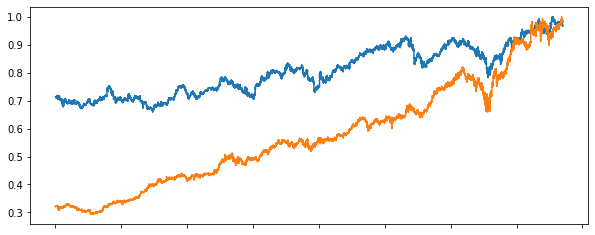

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(series[a]/series[a].max())
plt.plot(series[b]/series[b].max())
plt.xticks(visible=False);

### Analysis

This computation starts out by loading data from disk. We already know how to parallelize it:

```python
series = {}
for fn in filenames:
    series[fn] = pd.read_hdf(fn)['x']
```

It follows with a doubly nested for loop with an if statement.  

```python
results = {}
for a in filenames:
    for b in filenames:
        if a != b:
            results[a, b] = series[a].corr(series[b])
```

It *is* possible to solve this problem with `map`, but it requires some cleverness.  Instead we'll learn `submit`, an interface to start individual function calls asynchronously.

It finishes with a reduction on small data.  This part is fast enough.

```python
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
```

## Exercise 7.3
- Parallelize pair-wise correlations with `e.submit`
- Implement two versions one using Processes, another with Threads by replacing `e` with a ProcessPoolExecutor:

### Threads

```python
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(4)
```

### Processes

Be careful, a `ProcessPoolExecutor` does not run in the jupyter notebook cell.
You must run your file in a terminal.

```python
from concurrent.futures import ProcessPoolExecutor
e = ProcessPoolExecutor(4)
```

- How does performance vary?

Some conclusions about futures
----------------------------

*  `submit` functions can help us to parallelize more complex applications
*  It didn't actually speed up the code very much
*  Threads and Processes give some performance differences
*  This is not very robust.